In [78]:
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

from optimizers import *
from regularizers import *

import time_corex

Install CUDA and cudamat (for python) to enable GPU speedups.


# Test run

In [79]:
with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


In [80]:
starts = [0, 5, 10]
ends = [x + 10 for x in starts]
X = [df[s:e] for (s, e) in zip(starts, ends)]

corex = time_corex.Corex(n_hidden=10,
                         max_iter=300,
                         optimizer=Adam(),
                         regularizer=L2Reg(1))
corex.fit(X)

TC = 23.6273196861, reg = 0.39749312705, eps = 0.6
TC = 615.755086421, reg = 0.496923453088, eps = 0.6
TC = 1391.70062084, reg = 0.707115461075, eps = 0.6
TC = 1848.17024812, reg = 1.00917435126, eps = 0.6
TC = 2196.58762685, reg = 1.40639968901, eps = 0.6
TC = 2523.51716123, reg = 1.9084527956, eps = 0.6
TC = 2802.01269499, reg = 2.52512684716, eps = 0.6
TC = 3006.8957545, reg = 3.26687391225, eps = 0.6
TC = 3145.30307496, reg = 4.14555197638, eps = 0.6
TC = 3243.4385128, reg = 5.17205221959, eps = 0.6
TC = 3319.92481618, reg = 6.35492951521, eps = 0.6
TC = 3383.16366406, reg = 7.70049990968, eps = 0.6
TC = 3436.40296712, reg = 9.21296245049, eps = 0.6
TC = 3481.22478089, reg = 10.8939876966, eps = 0.6
TC = 3518.9467569, reg = 12.7421570692, eps = 0.6
TC = 3550.86647953, reg = 14.7524350196, eps = 0.6
TC = 3578.14620879, reg = 16.9156160047, eps = 0.6
TC = 3601.71495285, reg = 19.2177354308, eps = 0.6
TC = 3622.25571888, reg = 21.639574603, eps = 0.6
TC = 3640.23918318, reg = 24.15642

TC = 3755.10895118, reg = 30.5877890447, eps = 0.6
TC = 3755.15938943, reg = 30.5788715854, eps = 0.6
TC = 3755.21000751, reg = 30.5699298202, eps = 0.6
TC = 3755.26080457, reg = 30.5609675218, eps = 0.6
TC = 3755.31177997, reg = 30.5519887596, eps = 0.6
TC = 3755.36293316, reg = 30.5429976493, eps = 0.6
TC = 3755.41426362, reg = 30.5339981929, eps = 0.6
TC = 3755.46577074, reg = 30.5249940726, eps = 0.6
TC = 3755.5174538, reg = 30.5159886666, eps = 0.6
TC = 3755.56931195, reg = 30.5069851289, eps = 0.6
TC = 3755.62134419, reg = 30.497986417, eps = 0.6
TC = 3755.67354947, reg = 30.4889954365, eps = 0.6
TC = 3755.72592676, reg = 30.4800150806, eps = 0.6
TC = 3755.77847515, reg = 30.4710481956, eps = 0.6
TC = 3755.83119388, reg = 30.4620975828, eps = 0.6
TC = 3755.8840823, reg = 30.4531659174, eps = 0.6
TC = 3755.93713994, reg = 30.4442557649, eps = 0.6
TC = 3755.99036655, reg = 30.4353696063, eps = 0.6
TC = 3756.04376207, reg = 30.4265097623, eps = 0.6
TC = 3756.09732662, reg = 30.41767

TC = 6077.33357149, reg = 45.6134497129, eps = 0.36
TC = 6077.82978303, reg = 45.4455193299, eps = 0.36
TC = 6078.33311271, reg = 45.2972439729, eps = 0.36
TC = 6078.84354973, reg = 45.1778501222, eps = 0.36
TC = 6079.36091205, reg = 45.0928188688, eps = 0.36
TC = 6079.88474374, reg = 45.0440992172, eps = 0.36
TC = 6080.4141646, reg = 45.0305855621, eps = 0.36
TC = 6080.94787623, reg = 45.0487293169, eps = 0.36
TC = 6081.48441832, reg = 45.09321249, eps = 0.36
TC = 6082.02246145, reg = 45.1576338405, eps = 0.36
TC = 6082.56090881, reg = 45.2351562422, eps = 0.36
TC = 6083.09886632, reg = 45.3191141157, eps = 0.36
TC = 6083.63564468, reg = 45.403537788, eps = 0.36
TC = 6084.17080428, reg = 45.4835802448, eps = 0.36
TC = 6084.70415653, reg = 45.555794993, eps = 0.36
TC = 6085.23570827, reg = 45.6182326611, eps = 0.36
TC = 6085.76562353, reg = 45.6703723421, eps = 0.36
TC = 6086.29423024, reg = 45.7129107887, eps = 0.36
TC = 6086.82200652, reg = 45.7474740874, eps = 0.36
TC = 6087.3495021

TC = 6128.40427005, reg = 48.5548173427, eps = 0.36
TC = 6128.49058702, reg = 48.5595950278, eps = 0.36
TC = 6128.57624403, reg = 48.5643337121, eps = 0.36
TC = 6128.66125227, reg = 48.5690334343, eps = 0.36
TC = 6128.74562235, reg = 48.5736946191, eps = 0.36
TC = 6128.82936425, reg = 48.5783174624, eps = 0.36
TC = 6128.91248743, reg = 48.582902175, eps = 0.36
TC = 6128.99500078, reg = 48.5874488501, eps = 0.36
TC = 6129.07691268, reg = 48.5919576604, eps = 0.36
TC = 6129.158231, reg = 48.5964289355, eps = 0.36
TC = 6129.23896311, reg = 48.600862741, eps = 0.36
TC = 6129.31911598, reg = 48.6052594588, eps = 0.36
TC = 6129.3986961, reg = 48.6096191843, eps = 0.36
TC = 6129.47770958, reg = 48.6139422364, eps = 0.36
TC = 6129.55616213, reg = 48.618228807, eps = 0.36
TC = 6129.63405911, reg = 48.6224794888, eps = 0.36
TC = 6129.71140551, reg = 48.6266941863, eps = 0.36
TC = 6129.78820602, reg = 48.6308733952, eps = 0.36
TC = 6129.864465, reg = 48.6350171803, eps = 0.36
TC = 6129.94018651, 

TC = 7307.51511309, reg = 64.7828630218, eps = 0.216
TC = 7307.57529278, reg = 64.7943792333, eps = 0.216
TC = 7307.63519054, reg = 64.8062159567, eps = 0.216
TC = 7307.69492544, reg = 64.8197577218, eps = 0.216
TC = 7307.75461874, reg = 64.8358614869, eps = 0.216
TC = 7307.81436852, reg = 64.8548352143, eps = 0.216
TC = 7307.87423519, reg = 64.8765107927, eps = 0.216
TC = 7307.93424005, reg = 64.9003651047, eps = 0.216
TC = 7307.99436897, reg = 64.9256623881, eps = 0.216
TC = 7308.05457992, reg = 64.9516057522, eps = 0.216
TC = 7308.11481635, reg = 64.9774839504, eps = 0.216
TC = 7308.17502323, reg = 65.0027739958, eps = 0.216
TC = 7308.23516032, reg = 65.0271900834, eps = 0.216
TC = 7308.29520947, reg = 65.0506801839, eps = 0.216
TC = 7308.35517509, reg = 65.0733881943, eps = 0.216
TC = 7308.41507811, reg = 65.0955825081, eps = 0.216
TC = 7308.47494772, reg = 65.1175741467, eps = 0.216
TC = 7308.53481381, reg = 65.1396513557, eps = 0.216
TC = 7308.5947006, reg = 65.1620380382, eps = 

TC = 7314.56689976, reg = 67.9538495972, eps = 0.216
TC = 7314.58320064, reg = 67.9641989534, eps = 0.216
TC = 7314.59932694, reg = 67.9744063691, eps = 0.216
TC = 7314.61528353, reg = 67.9844740225, eps = 0.216
TC = 7314.63107529, reg = 67.994403619, eps = 0.216
TC = 7314.64670705, reg = 68.0041967539, eps = 0.216
TC = 7314.66218367, reg = 68.0138552925, eps = 0.216
TC = 7314.67750997, reg = 68.0233816908, eps = 0.216
TC = 7314.69269077, reg = 68.0327772874, eps = 0.216
TC = 7314.70773089, reg = 68.0420445381, eps = 0.216
TC = 7314.72263513, reg = 68.051185721, eps = 0.216
TC = 7314.73740828, reg = 68.06020248, eps = 0.216
TC = 7314.75205516, reg = 68.0690965735, eps = 0.216
TC = 7314.76658059, reg = 68.077871184, eps = 0.216
TC = 7314.78098935, reg = 68.0865280442, eps = 0.216
TC = 7314.79528623, reg = 68.095069169, eps = 0.216
TC = 7314.80947605, reg = 68.1034971802, eps = 0.216
TC = 7314.82356361, reg = 68.111814325, eps = 0.216
TC = 7314.83755371, reg = 68.1200227658, eps = 0.216


TC = 7821.4106548, reg = 83.4978445362, eps = 0.1296
TC = 7821.52815665, reg = 83.5708643594, eps = 0.1296
TC = 7821.64560724, reg = 83.6432947922, eps = 0.1296
TC = 7821.7629683, reg = 83.7151349512, eps = 0.1296
TC = 7821.88019229, reg = 83.7863897115, eps = 0.1296
TC = 7821.99721539, reg = 83.8571058394, eps = 0.1296
TC = 7822.11395593, reg = 83.9273295754, eps = 0.1296
TC = 7822.23031634, reg = 83.9970895651, eps = 0.1296
TC = 7822.34618357, reg = 84.0664069303, eps = 0.1296
TC = 7822.46142641, reg = 84.1352653752, eps = 0.1296
TC = 7822.57589327, reg = 84.2036097761, eps = 0.1296
TC = 7822.68941448, reg = 84.2713741966, eps = 0.1296
TC = 7822.80180721, reg = 84.3384329007, eps = 0.1296
TC = 7822.9128771, reg = 84.4047144739, eps = 0.1296
TC = 7823.02241551, reg = 84.4700768493, eps = 0.1296
TC = 7823.13019656, reg = 84.5344665196, eps = 0.1296
TC = 7823.23597791, reg = 84.5978252828, eps = 0.1296
TC = 7823.3395051, reg = 84.6600848107, eps = 0.1296
TC = 7823.4405178, reg = 84.7212

TC = 7826.30371727, reg = 89.1029840984, eps = 0.1296
TC = 7826.30872301, reg = 89.1223307514, eps = 0.1296
TC = 7826.31368368, reg = 89.1416003099, eps = 0.1296
TC = 7826.31860014, reg = 89.1607930154, eps = 0.1296
TC = 7826.32347322, reg = 89.1799098251, eps = 0.1296
TC = 7826.32830376, reg = 89.198950413, eps = 0.1296
TC = 7826.33309257, reg = 89.2179180546, eps = 0.1296
TC = 7826.33784048, reg = 89.2368093899, eps = 0.1296
TC = 7826.34254829, reg = 89.2556308912, eps = 0.1296
TC = 7826.34721679, reg = 89.2743750983, eps = 0.1296
TC = 7826.35184678, reg = 89.2930526354, eps = 0.1296
TC = 7826.35643902, reg = 89.3116543466, eps = 0.1296
TC = 7826.36099429, reg = 89.3301900634, eps = 0.1296
TC = 7826.36551336, reg = 89.3486527191, eps = 0.1296
TC = 7826.36999695, reg = 89.3670490455, eps = 0.1296
TC = 7826.37444583, reg = 89.3853763092, eps = 0.1296
TC = 7826.37886071, reg = 89.4036359268, eps = 0.1296
TC = 7826.38324231, reg = 89.4218312479, eps = 0.1296
TC = 7826.38759135, reg = 89.

TC = 8023.06798417, reg = 102.222970625, eps = 0.07776
TC = 8023.07567506, reg = 102.286550743, eps = 0.07776
TC = 8023.08338357, reg = 102.349915316, eps = 0.07776
TC = 8023.0911103, reg = 102.413070986, eps = 0.07776
TC = 8023.09885262, reg = 102.476063742, eps = 0.07776
TC = 8023.10660749, reg = 102.538923322, eps = 0.07776
TC = 8023.11437475, reg = 102.601689961, eps = 0.07776
TC = 8023.12215803, reg = 102.664375534, eps = 0.07776
TC = 8023.12996259, reg = 102.72697166, eps = 0.07776
TC = 8023.13779207, reg = 102.789466111, eps = 0.07776
TC = 8023.14564662, reg = 102.851826762, eps = 0.07776
TC = 8023.15352456, reg = 102.914047062, eps = 0.07776
TC = 8023.16142529, reg = 102.976112471, eps = 0.07776
TC = 8023.16935044, reg = 103.038039926, eps = 0.07776
TC = 8023.17730271, reg = 103.099847357, eps = 0.07776
TC = 8023.18528433, reg = 103.161553067, eps = 0.07776
TC = 8023.19329672, reg = 103.223180306, eps = 0.07776
TC = 8023.20134095, reg = 103.284734002, eps = 0.07776
TC = 8023.20

TC = 8030.35575663, reg = 118.043495748, eps = 0.07776
TC = 8030.5481958, reg = 118.232471461, eps = 0.07776
TC = 8030.72609564, reg = 118.420490688, eps = 0.07776
TC = 8030.88717921, reg = 118.607342543, eps = 0.07776
TC = 8031.03015915, reg = 118.792760482, eps = 0.07776
TC = 8031.15497747, reg = 118.976738313, eps = 0.07776
TC = 8031.26290953, reg = 119.159308815, eps = 0.07776
TC = 8031.35648503, reg = 119.340705503, eps = 0.07776
TC = 8031.43921117, reg = 119.5213255, eps = 0.07776
TC = 8031.51512824, reg = 119.701635344, eps = 0.07776
TC = 8031.58827306, reg = 119.882260308, eps = 0.07776
TC = 8031.66215548, reg = 120.063734597, eps = 0.07776
TC = 8031.73935504, reg = 120.246575755, eps = 0.07776
TC = 8031.821315, reg = 120.431088269, eps = 0.07776
TC = 8031.90835885, reg = 120.617358905, eps = 0.07776
TC = 8031.99989823, reg = 120.805254347, eps = 0.07776
TC = 8032.09475901, reg = 120.994387148, eps = 0.07776
TC = 8032.19153762, reg = 121.184265415, eps = 0.07776
TC = 8032.28891

TC = 8116.14251271, reg = 151.238542224, eps = 0.046656
TC = 8116.16057844, reg = 151.421622794, eps = 0.046656
TC = 8116.17855467, reg = 151.60441846, eps = 0.046656
TC = 8116.19644441, reg = 151.787058225, eps = 0.046656
TC = 8116.21424728, reg = 151.969493175, eps = 0.046656
TC = 8116.23196369, reg = 152.15170837, eps = 0.046656
TC = 8116.24959584, reg = 152.333782348, eps = 0.046656
TC = 8116.26714629, reg = 152.515629408, eps = 0.046656
TC = 8116.284618, reg = 152.697346669, eps = 0.046656
TC = 8116.30201423, reg = 152.878836408, eps = 0.046656
TC = 8116.31933425, reg = 153.060190214, eps = 0.046656
TC = 8116.33656968, reg = 153.241315809, eps = 0.046656
TC = 8116.35370785, reg = 153.422305939, eps = 0.046656
TC = 8116.3707374, reg = 153.603076499, eps = 0.046656
TC = 8116.38764918, reg = 153.783692615, eps = 0.046656
TC = 8116.40443561, reg = 153.964127695, eps = 0.046656
TC = 8116.42109369, reg = 154.144363188, eps = 0.046656
TC = 8116.4376284, reg = 154.324461804, eps = 0.04665

TC = 8117.77862687, reg = 176.655737414, eps = 0.046656
TC = 8117.78492369, reg = 176.815014081, eps = 0.046656
TC = 8117.79119107, reg = 176.974101324, eps = 0.046656
TC = 8117.797429, reg = 177.133083993, eps = 0.046656
TC = 8117.80363811, reg = 177.291945639, eps = 0.046656
TC = 8117.80981817, reg = 177.450668128, eps = 0.046656
TC = 8117.81597006, reg = 177.6092663, eps = 0.046656
TC = 8117.82209315, reg = 177.767768578, eps = 0.046656
TC = 8117.82818888, reg = 177.926077402, eps = 0.046656
TC = 8117.83425581, reg = 178.084375632, eps = 0.046656
TC = 8117.84029656, reg = 178.242399335, eps = 0.046656
TC = 8117.84630797, reg = 178.400483183, eps = 0.046656
TC = 8117.85229506, reg = 178.558240633, eps = 0.046656
TC = 8117.85825124, reg = 178.716096853, eps = 0.046656
TC = 8117.86418642, reg = 178.873601259, eps = 0.046656
TC = 8117.87008692, reg = 179.031231427, eps = 0.046656
TC = 8117.87597287, reg = 179.188466171, eps = 0.046656
TC = 8117.88181576, reg = 179.345907901, eps = 0.046

TC = 8167.57929546, reg = 221.125949699, eps = 0
TC = 8167.59294058, reg = 221.378040771, eps = 0
TC = 8167.60653887, reg = 221.629717772, eps = 0
TC = 8167.62004387, reg = 221.8810981, eps = 0
TC = 8167.63340829, reg = 222.132064422, eps = 0
TC = 8167.64659947, reg = 222.382740239, eps = 0
TC = 8167.65960879, reg = 222.633002484, eps = 0
TC = 8167.67244645, reg = 222.883018648, eps = 0
TC = 8167.6851309, reg = 223.132715595, eps = 0
TC = 8167.69768416, reg = 223.382116196, eps = 0
TC = 8167.71013483, reg = 223.631369531, eps = 0
TC = 8167.72252611, reg = 223.880279929, eps = 0
TC = 8167.73490785, reg = 224.12908543, eps = 0
TC = 8167.7473145, reg = 224.377642763, eps = 0
TC = 8167.75975625, reg = 224.62593565, eps = 0
TC = 8167.77223321, reg = 224.874158068, eps = 0
TC = 8167.78475099, reg = 225.121938208, eps = 0
TC = 8167.79731507, reg = 225.369702262, eps = 0
TC = 8167.80991717, reg = 225.617007659, eps = 0
TC = 8167.82253414, reg = 225.864174617, eps = 0
TC = 8167.83513818, reg = 

In [81]:
print corex.tc
print sum(corex.tc)

[2738.3782496707704, 2743.9050114961342, 2687.030801579454]
8169.31406275


# Replicate the experiment from time-varying GLASSO

In [82]:
with open('../data/EOD_day.pkl', 'rb') as f:
    day_df = pd.DataFrame(pkl.load(f))

print("Data.shape = {}".format(day_df.shape))

Data.shape = (4277, 5038)


In [83]:
df_2010 = day_df[day_df.index >= '2010-01-01']
df_2010 = df_2010[df_2010.index <= '2012-01-01']  # NOTE: 2 years
X = []
for i in range(1, 2*365//14 - 2):
    week_start = 10 * i
    week_end = 10 * (i + 1)
    X.append(df_2010[week_start : week_end])  # two weeks
print [len(x) for x in X]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [84]:
corex_2010 = time_corex.Corex(n_hidden=10,
                              max_iter=150,
                              tol=1,
                              optimizer=Adam(),
                              regularizer=L2Reg(10000.0),
                              verbose=True)
corex_2010.fit(X)

Linear CorEx with 10 latent factors
TC = 907.808334678, reg = 29573.6336139, eps = 0.6
TC = 658.492776409, reg = 16519.975913, eps = 0.6
TC = 618.822993227, reg = 16283.7969953, eps = 0.6
TC = 607.840703108, reg = 16847.4353302, eps = 0.6
TC = 585.602635546, reg = 15816.5213488, eps = 0.6
TC = 575.421917403, reg = 13891.3409478, eps = 0.6
TC = 583.892208909, reg = 11825.3093031, eps = 0.6
TC = 600.657478055, reg = 10042.1771271, eps = 0.6
TC = 611.253061757, reg = 8719.89835643, eps = 0.6
8 iterations to tol: 1.000000, Time: 3.55946087837
TC = 1073.81235565, reg = 8295.20002489, eps = 0.36
TC = 1080.80970997, reg = 7334.08826124, eps = 0.36
TC = 1098.92575757, reg = 6509.80218281, eps = 0.36
TC = 1124.75527982, reg = 5805.5197598, eps = 0.36
TC = 1155.946744, reg = 5226.58861911, eps = 0.36
TC = 1195.06671634, reg = 4751.64519784, eps = 0.36
TC = 1248.73273743, reg = 4329.42688408, eps = 0.36
TC = 1323.69422506, reg = 3921.59031778, eps = 0.36
TC = 1423.51043021, reg = 3527.45924636, e

TC = 90165.3899607, reg = 154418.125905, eps = 0.216
TC = 90470.7058174, reg = 158406.814068, eps = 0.216
TC = 90767.5252637, reg = 162570.697792, eps = 0.216
TC = 91056.5739873, reg = 166912.459911, eps = 0.216
TC = 91338.5551373, reg = 171432.328328, eps = 0.216
TC = 91614.2473132, reg = 176128.441507, eps = 0.216
TC = 91884.3690558, reg = 180997.162893, eps = 0.216
TC = 92149.6462261, reg = 186033.505254, eps = 0.216
TC = 92410.8834898, reg = 191231.359876, eps = 0.216
TC = 92668.7699028, reg = 196583.570119, eps = 0.216
TC = 92923.9386954, reg = 202081.675388, eps = 0.216
TC = 93177.0517963, reg = 207715.380489, eps = 0.216
TC = 93428.393517, reg = 213472.200503, eps = 0.216
TC = 93678.2941327, reg = 219337.055087, eps = 0.216
TC = 93926.5524753, reg = 225292.044472, eps = 0.216
TC = 94172.9607498, reg = 231316.230128, eps = 0.216
TC = 94416.9709578, reg = 237385.327726, eps = 0.216
TC = 94657.9376872, reg = 243471.494322, eps = 0.216
TC = 94895.0292426, reg = 249543.209152, eps = 

TC = 126139.036035, reg = 338440.758614, eps = 0.1296
TC = 126323.687129, reg = 336191.701148, eps = 0.1296
TC = 126509.762021, reg = 333988.821063, eps = 0.1296
TC = 126697.531818, reg = 331831.554967, eps = 0.1296
TC = 126886.749141, reg = 329720.151613, eps = 0.1296
TC = 127077.33151, reg = 327655.192922, eps = 0.1296
TC = 127269.379207, reg = 325637.845987, eps = 0.1296
TC = 127462.598045, reg = 323669.537822, eps = 0.1296
TC = 127657.06934, reg = 321751.895015, eps = 0.1296
TC = 127852.644643, reg = 319886.963313, eps = 0.1296
TC = 128049.237061, reg = 318076.694908, eps = 0.1296
TC = 128246.864614, reg = 316323.370392, eps = 0.1296
TC = 128445.410948, reg = 314629.17574, eps = 0.1296
TC = 128644.753571, reg = 312996.638355, eps = 0.1296
TC = 128844.892538, reg = 311428.195185, eps = 0.1296
TC = 129045.754679, reg = 309926.691167, eps = 0.1296
TC = 129247.142773, reg = 308494.725622, eps = 0.1296
TC = 129449.308305, reg = 307134.999876, eps = 0.1296
TC = 129651.895464, reg = 30584

TC = 162783.413345, reg = 325345.510779, eps = 0.07776
TC = 163061.882863, reg = 323835.383018, eps = 0.07776
TC = 163341.9091, reg = 322433.912849, eps = 0.07776
TC = 163621.733411, reg = 321141.255827, eps = 0.07776
TC = 163902.374746, reg = 319953.837943, eps = 0.07776
TC = 164183.053083, reg = 318866.075985, eps = 0.07776
TC = 164463.340887, reg = 317873.960285, eps = 0.07776
TC = 164743.704695, reg = 316968.01092, eps = 0.07776
TC = 165022.78351, reg = 316142.722136, eps = 0.07776
TC = 165301.511685, reg = 315389.050241, eps = 0.07776
TC = 165578.610238, reg = 314698.501033, eps = 0.07776
TC = 165854.602313, reg = 314065.882851, eps = 0.07776
TC = 166128.625569, reg = 313481.051931, eps = 0.07776
TC = 166400.945056, reg = 312942.203392, eps = 0.07776
TC = 166670.690872, reg = 312441.768618, eps = 0.07776
TC = 166938.126089, reg = 311977.655286, eps = 0.07776
TC = 167202.629413, reg = 311546.943388, eps = 0.07776
TC = 167464.012436, reg = 311146.977715, eps = 0.07776
TC = 167722.38

TC = 190887.828176, reg = 384267.273401, eps = 0.046656
TC = 191017.996692, reg = 386895.761425, eps = 0.046656
TC = 191146.27707, reg = 389432.756445, eps = 0.046656
TC = 191271.020439, reg = 391870.377429, eps = 0.046656
TC = 191394.381185, reg = 394195.752655, eps = 0.046656
TC = 191513.99027, reg = 396413.61264, eps = 0.046656
TC = 191632.185329, reg = 398517.875732, eps = 0.046656
TC = 191746.927984, reg = 400513.653313, eps = 0.046656
TC = 191860.193773, reg = 402396.773773, eps = 0.046656
TC = 191970.693009, reg = 404171.684875, eps = 0.046656
TC = 192080.505921, reg = 405834.333384, eps = 0.046656
TC = 192188.819268, reg = 407396.407852, eps = 0.046656
TC = 192297.507456, reg = 408860.917449, eps = 0.046656
TC = 192406.085345, reg = 410244.760764, eps = 0.046656
TC = 192515.805184, reg = 411557.320962, eps = 0.046656
TC = 192626.029445, reg = 412817.068815, eps = 0.046656
TC = 192737.745705, reg = 414031.488362, eps = 0.046656
TC = 192849.206523, reg = 415211.071344, eps = 0.04

In [85]:
W = [corex_2010.getW(w, x) for w,x in zip(corex_2010.ws, corex_2010.x)]
corex_2010.regularizer.regularize(W) / corex_2010.regularizer.alpha

37.017462634655331

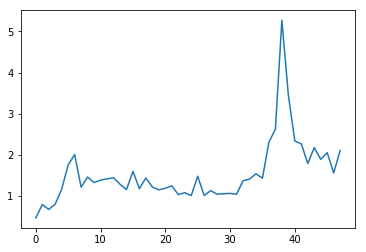

In [86]:
diff = [np.square(W[t+1] - W[t]).sum() for t in range(len(W) - 1)]
plt.plot(diff)
plt.show()

In [87]:
covs = corex_2010.get_covariance()
covs_diff = [np.square(covs[t+1] - covs[t]).sum() for t in range(len(W) - 1)]

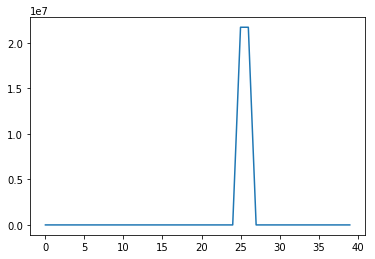

In [88]:
#covs_diff[25]=0
#covs_diff[26]=0
plt.plot(covs_diff[:40])
plt.show()

# TODOS 
1. compare single vs reg in sense of sum(TC)
2. understand why covariance difference is exactly the same for single and regularized models